# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
from fastai.text import *
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [4]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [5]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [6]:
import numpy as np
import torch.nn as nn

In [7]:
path = Path('../../data/midi/v10/midi_encode/')

## Single Stream Encoding

In [8]:
config = v10_single_config(path/'tmp/all'); config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 12,
 'd_model': 256,
 'd_head': 64,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 262, 256)],
 'idx_map': {0: (0, 262, 256)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'enc_offset': 3,
 'transpose_range': (0, 12),
 'mask_type': <MaskType.RandomWindow: 3>,
 'bs': 16,
 'bptt': 256,
 'single_stream': True}

In [9]:
data = load_data(path, cache_name='tmp/sample', **config)

In [10]:
learn = load_learner(data, config)

In [11]:
learn.validate()

[5.945253, tensor(0.)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


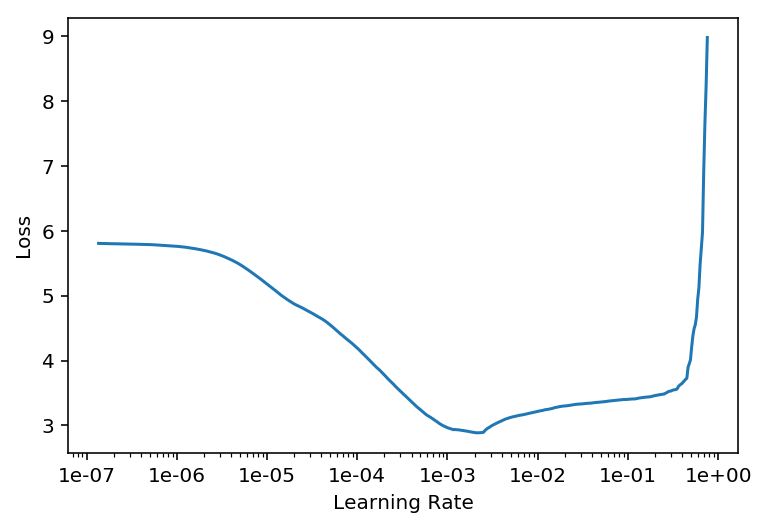

In [12]:
# # clip = 0.5
learn.lr_find(num_it=600)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


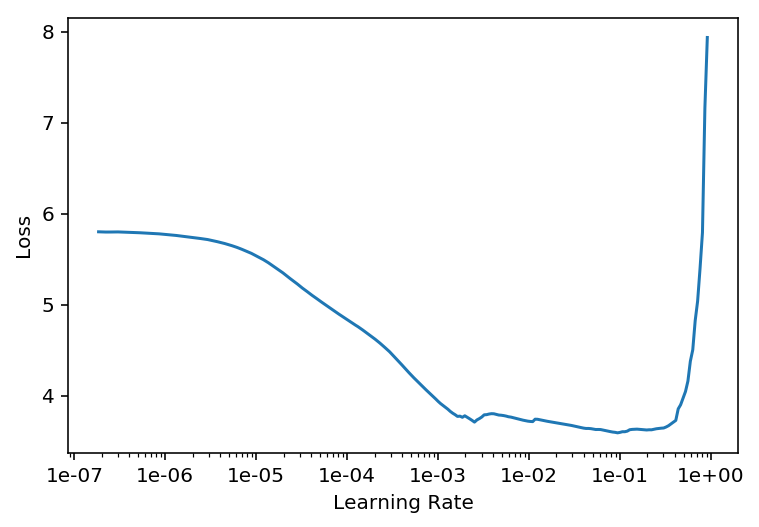

In [12]:
# # clip = 0.5
learn.lr_find(num_it=300)
learn.recorder.plot()

In [12]:
# relu
learn.fit_one_cycle(1, 4e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,1.875336,1.772942,0.499271,05:28


In [12]:
# relu
learn.fit_one_cycle(1, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,1.977311,1.864041,0.477630,05:29


## Double Stream Encoding

In [13]:
config = v10_config(path/'tmp/all'); config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 12,
 'd_model': 256,
 'd_head': 64,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 130, 128), (1, 132, 128)],
 'idx_map': {0: (0, 130, 128), 1: (1, 132, 128)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'enc_offset': 3,
 'transpose_range': (0, 12),
 'mask_type': <MaskType.RandomWindow: 3>,
 'bs': 16,
 'bptt': 256}

In [14]:
data = load_data(path, cache_name='tmp/sample', **config)

In [15]:
learn = load_learner(data, config)

In [16]:
learn.validate()

[9.725336, tensor(0.0094)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


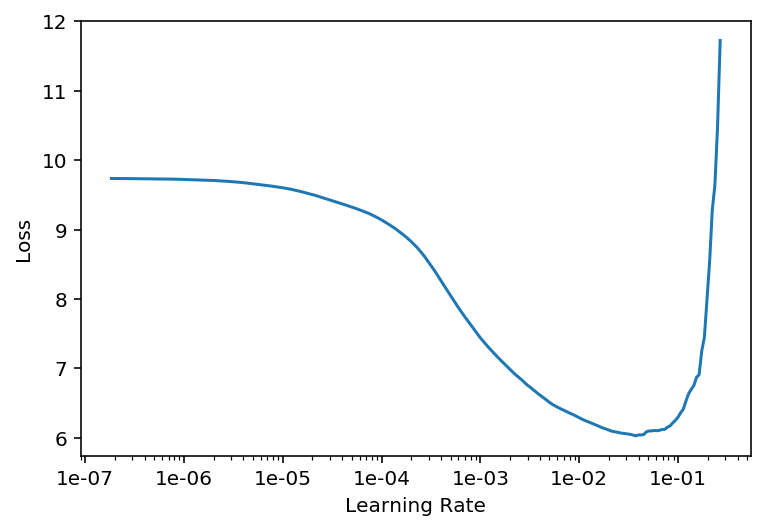

In [17]:
# # clip = 0.5
learn.lr_find(num_it=300)
learn.recorder.plot()

In [12]:
# relu
learn.fit_one_cycle(1, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,4.133816,4.030482,0.448240,02:46


In [18]:
# relu
learn.fit_one_cycle(1, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,4.335164,4.221336,0.428890,02:46


## Prediction

In [13]:
x,y = data.one_batch(cpu=False)

In [14]:
out,seed = learn.predict(x, n_words=100)

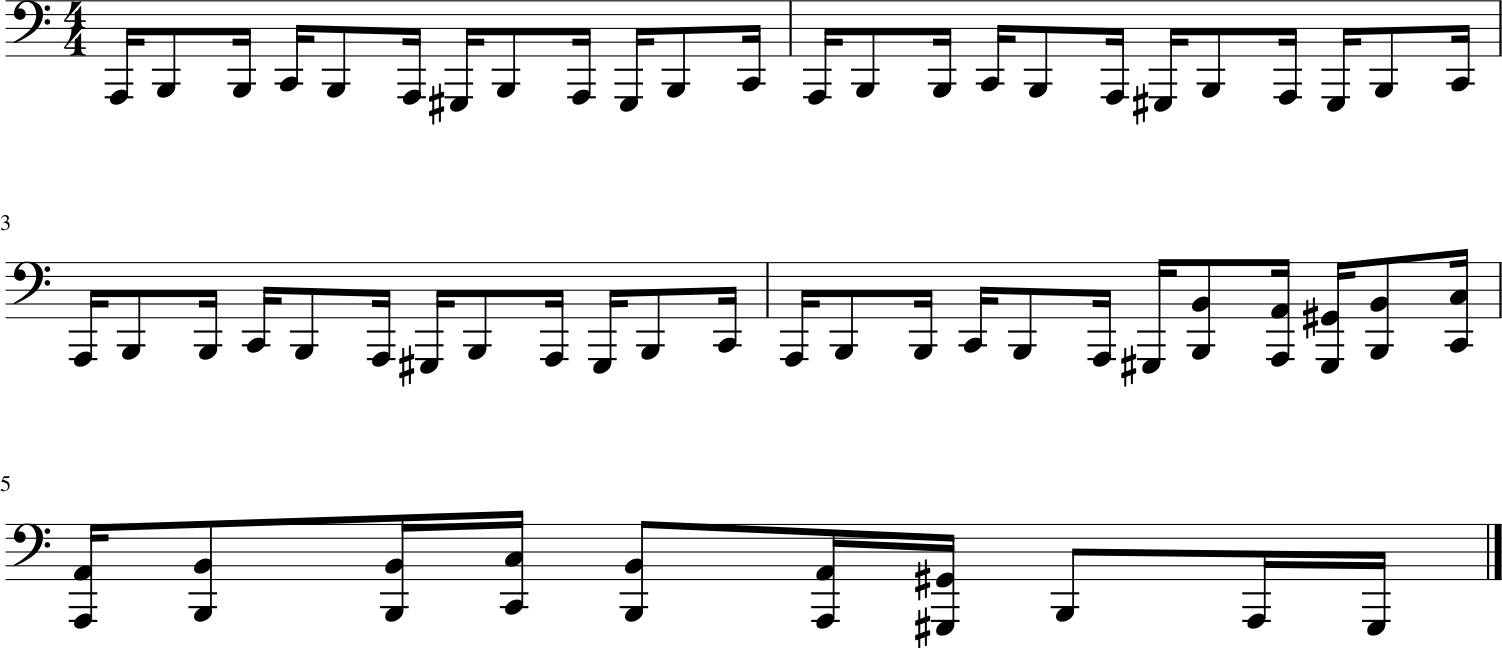

In [20]:
stream = npenc2stream(to_double_stream(seed))
stream.show()

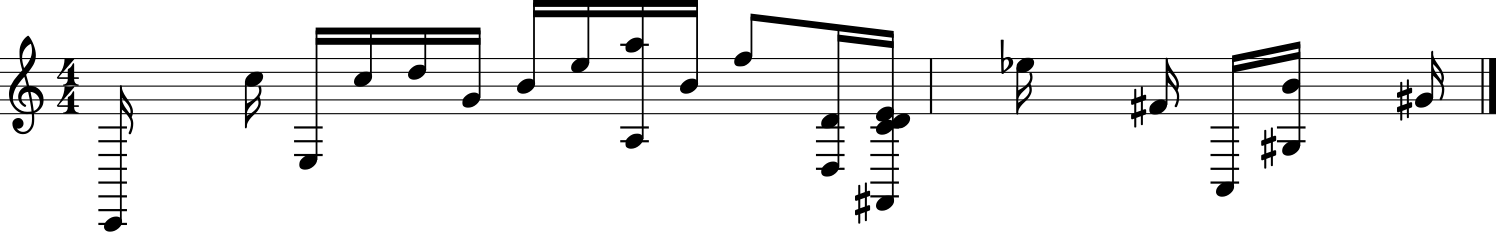

In [21]:
stream = npenc2stream(to_double_stream(out))
stream.show()

In [36]:
# ob = data.one_batch(cpu=False)
# out = learn.model(ob[0])
# out = learn.pred_batch(ob)
# learn.loss_func([c.cuda() for c in out], ob[1])

In [37]:
# # # clip = 0.5
# learn.lr_find(num_it=300)
# learn.recorder.plot()

In [38]:
# learn.to_fp16();

### Run 2

In [39]:
# relu
learn.fit_one_cycle(4, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,4.462585,3.509509,0.548042,02:09
1,3.721648,3.308317,0.509911,02:09
2,3.412720,2.950449,0.548208,02:09
3,3.429547,2.876465,0.563198,02:10


In [43]:
# gelu
learn.fit_one_cycle(4, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,4.343354,3.373704,0.536694,02:18
1,3.574547,3.185786,0.515622,02:17
2,3.417778,2.864015,0.583908,02:17
3,3.374456,2.785271,0.593978,02:17


In [41]:
learn.validate()

[7.566925, tensor(0.2803)]

In [43]:
learn.save('first_run_10ep')

In [46]:
learn.fit_one_cycle(5, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,1.337372,1.288798,0.932526,14:50
1,1.382319,1.416606,0.927723,14:51
2,1.282228,1.287018,0.932393,14:55
3,1.221084,1.222616,0.935772,14:53
4,1.270180,1.200249,0.937181,14:54


In [42]:
from fastai import basic_train

In [43]:
def predict_func(parts): return [F.softmax(p, dim=-1) for p in parts]

In [44]:
loss_func_name = camel2snake(learn.loss_func.__class__.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func
basic_train._loss_func2activ(learn.loss_func)

<function __main__.predict_func(parts)>

In [45]:
# bos_idx = enc_config.enc_offset+enc_config.bos_idx
bos_idx = VALTBOS

def predict(self, xb, n_words:int=1, temperature:float=1., min_p:float=None, bos_idx:None):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    learn.model[0].mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy()
    yb = torch.ones_like(xb)
    timesteps = []
    for _ in progress_bar(range(n_words), leave=True):
        bar = get_positions(xb) if BIDX_ALL else []
        outputs = learn.pred_batch(batch=(xb,yb))
        for item in outputs: #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            if min_p is not None: 
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1)
#             val,idx = torch.topk(res, 1)
            bar.append(idx.squeeze().to(xb.device))
        bar = torch.stack(bar, dim=-1)
        if (bar==bos_idx).any(): 
            print('Predicted BOS token. Returning prediction...')
            break
        timesteps.append(bar.cpu().numpy())
        xb = bar.clone().detach()[None,None] # don't use timesteps. use it's own memory instead
    
    learn.model[0].mask = True
    return timesteps, seed.squeeze()


### From batch

In [46]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [47]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [48]:
# Loading from specific file
keywords = ['third', 'eye']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/hows-it-going-to-be/intro_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/hows-it-going-to-be/verse_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/h

In [49]:
# file = np.random.choice(files)
file = search[-2]
file

PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/semi-charmed-life/intro_key_cmajor.npy')

In [50]:
#good_one = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# la_bamba = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/r/ritchie-valen/la-bamba/chorus.npy')
# third_eye = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [51]:
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np).cuda()[None]

### Predict

In [52]:
out, seed = predict(learn, xb, n_words=340, temperature=.7, min_p=0.01)

### Actual prediction

In [59]:
seq = npenc2seq(np.array(out))
chordarr = seq2chordarr(seq)
stream = chordarr2stream(chordarr)

Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing


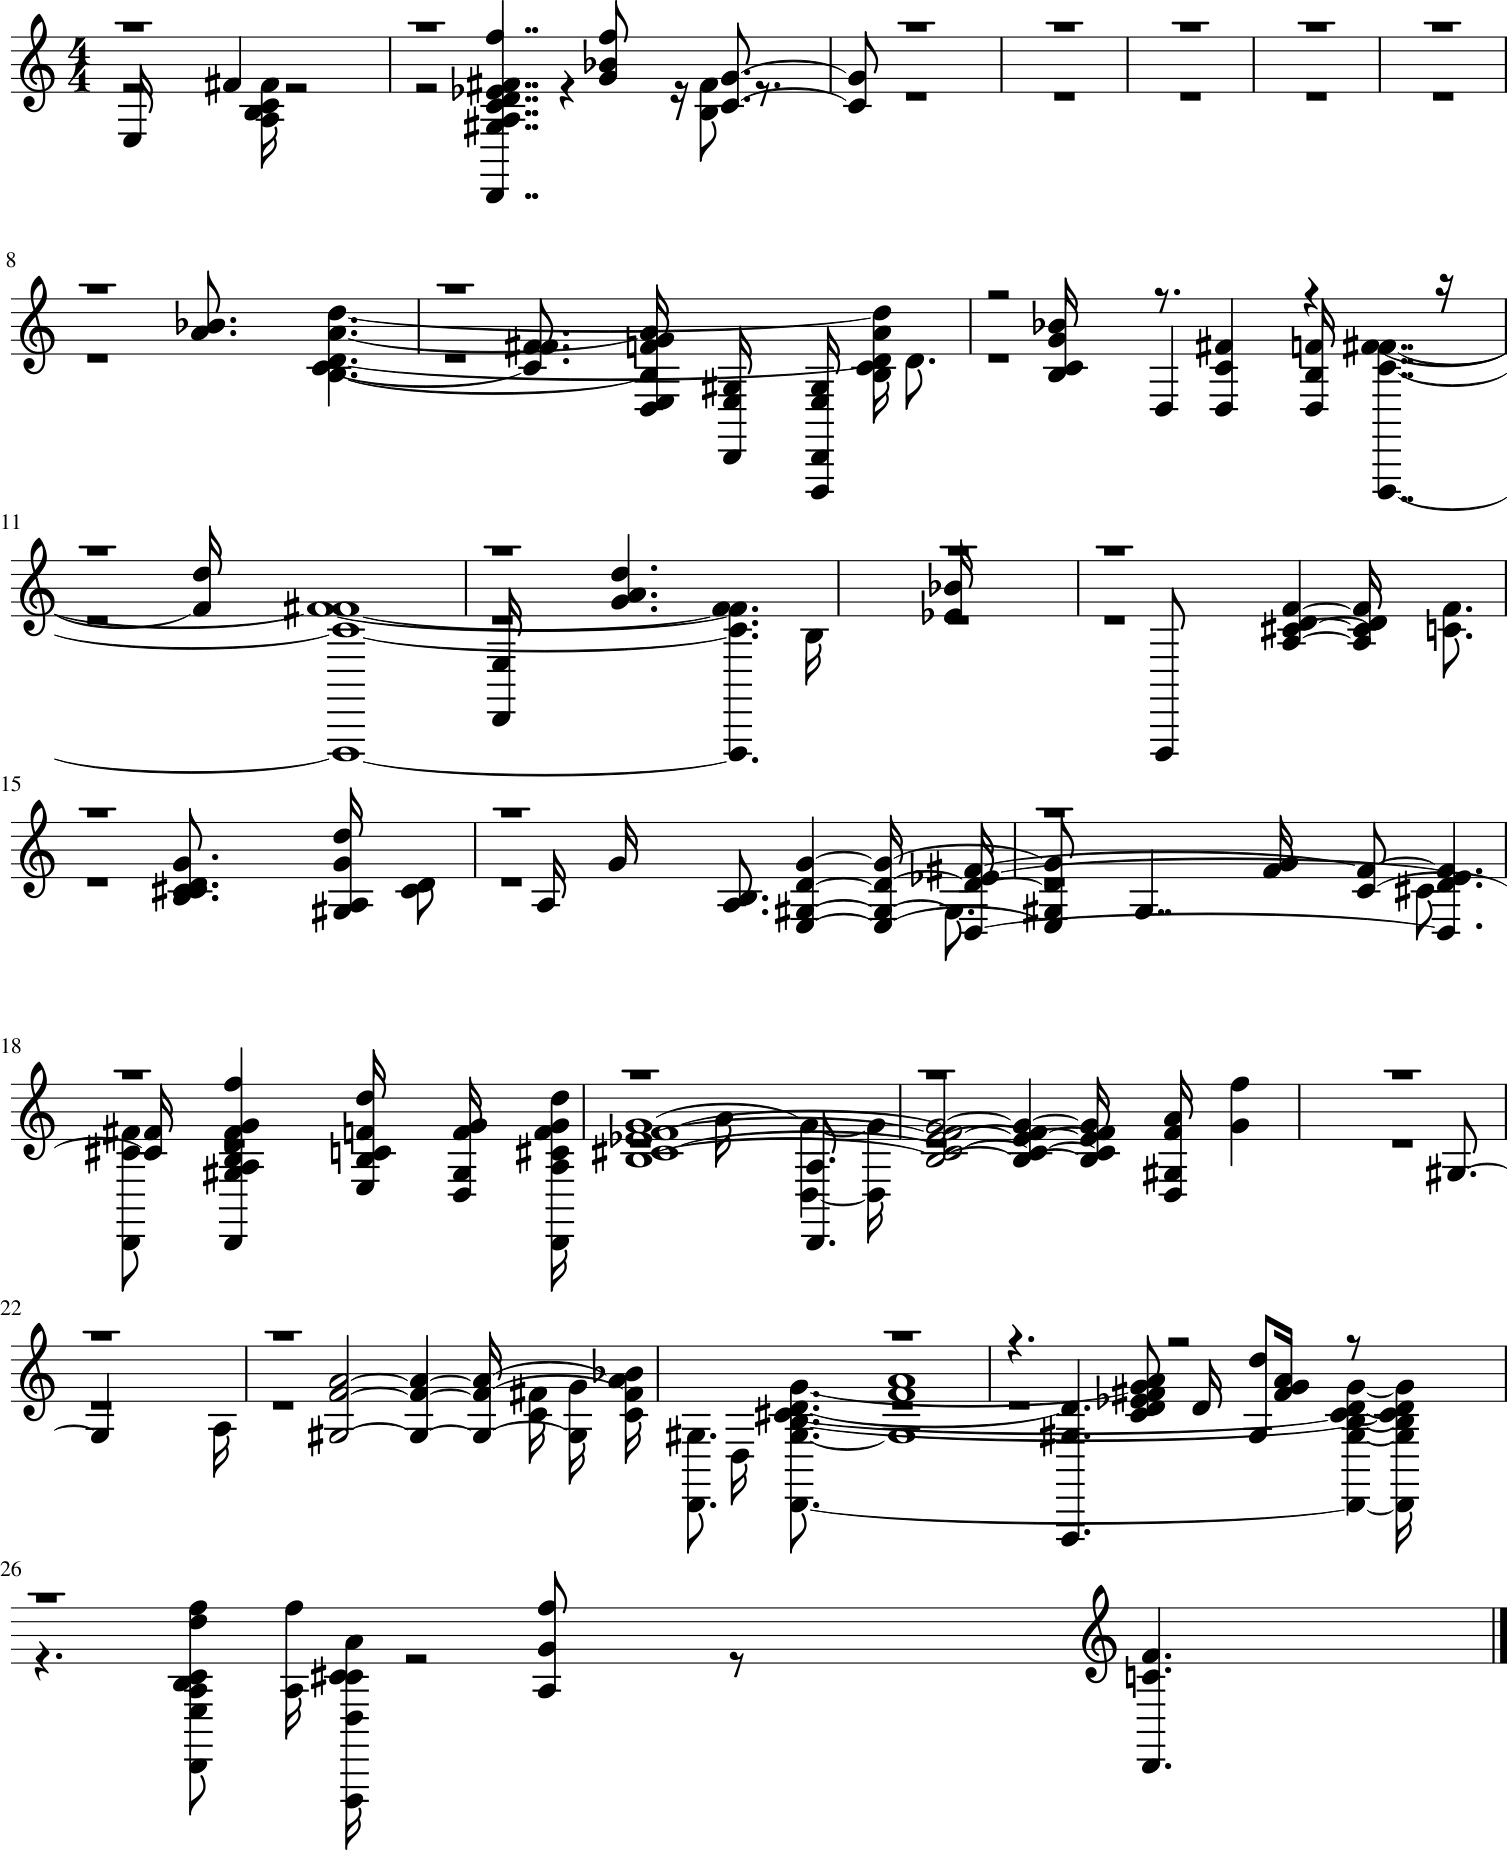

In [60]:
stream.show()

In [61]:
stream.show('midi')

## Seed

In [434]:
seed_song = dec_arr(seed)
seed_stream = seed_song.to_stream()

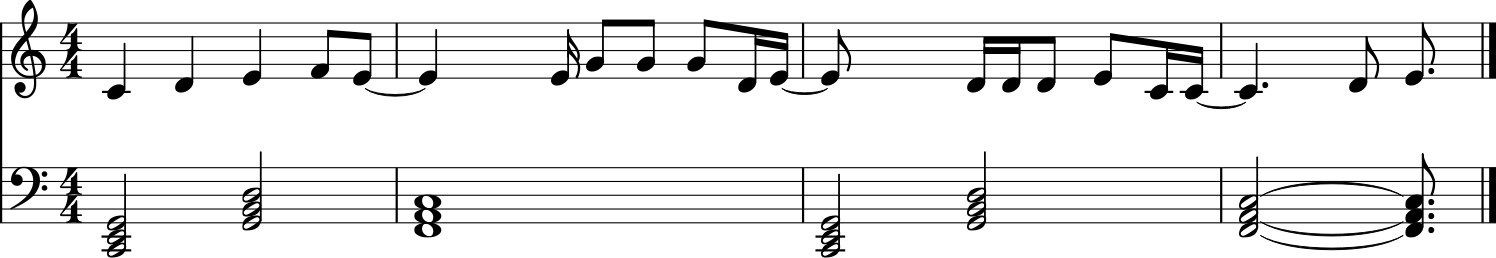

In [435]:
seed_stream.show()

In [436]:
seed_stream.show('midi')